In [1]:
import os
import cv2
import math
import keras
import imutils

import numpy as np 
import matplotlib.pyplot as plt
import segmentation_models as sm

import imgaug.augmenters as iaa

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.utils import shuffle
# from keras.applications.vgg16 import VGG16
# from keras.models import Model

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
# seq = iaa.Sequential([
#     iaa.Flipud(1), # crop images from each side by 0 to 16px (randomly chosen)
#     iaa.Fliplr(1), # horizontally flip 50% of the images
# ])


In [3]:
train_dir = "../data/train"
test_dir = "../data/test"
validation_dir = "../data/validation"

In [4]:
def fit_shape(img):
    x, y = img.shape[:2]

    mod_x = x % 32
    mod_y = y % 32

    return img[:x - mod_x, :y - mod_y]


In [5]:
def thresholder(img):
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

    thresh[thresh != 0] = 1
    
    return thresh
    

In [6]:
def data_reader(dir_name):

    imgs_dir_name = os.path.join(dir_name, 'imgs')
    masks_dir_name = os.path.join(dir_name, 'masks')

    imgs_names = [os.path.join(imgs_dir_name, name) for name in os.listdir(imgs_dir_name)]
    masks_names = [os.path.join(masks_dir_name, name) for name in os.listdir(masks_dir_name)]

    imgs = np.array([fit_shape(cv2.imread(name)) for name in imgs_names])
    masks = np.array([fit_shape(thresholder(cv2.imread(name, 0))) for name in masks_names])
    
    masks = np.array([i.reshape((*i.shape, 1)) for i in masks])
    print(imgs[0].shape, masks[0].shape)
    
    
    return imgs, masks#masks.reshape((*masks.shape, 1))

In [7]:
# width, height = 640, 480

train_x, train_y = data_reader(train_dir)
test_x, test_y = data_reader(test_dir)
val_x, val_y = data_reader(validation_dir)

(480, 832, 3) (480, 832, 1)
(480, 832, 3) (480, 832, 1)
(480, 832, 3) (480, 832, 1)


In [8]:
def rotator(x, y):
#     print("shape before", x.shape)
    images_aug = []
    masks_aug = []
    aug_x, aug_y = [], []
    
    for angle in (0, 45, 90, 135, 180, 225, 270, 315):
        
        for x_i, y_i in zip(x, y):
            x_i, y_i = np.array([x_i]), np.array([y_i])
    #         print(x_i.shape, y_i.shape)
            img, mask = iaa.Affine(rotate=(angle))(images=x_i, segmentation_maps=y_i)
            images_aug.extend(img)
            masks_aug.extend(mask)
        
#         images_aug, masks_aug = iaa.Affine(rotate=(angle))(images=x, segmentation_maps=y)
        aug_x.append(images_aug), aug_y.append(masks_aug)
        
    
    x, y = np.array(aug_x), np.array(aug_y)
#     print("shape after", x.shape)
    
    x = x.reshape(-1, *x.shape[2:])
    y = y.reshape(-1, *y.shape[2:])
    
#     print("after reshape", x.shape)
    
    return x, y

In [9]:
def blurring(x, y):    

    images_aug, masks_aug = iaa.GaussianBlur(sigma=0.2)(images=x, segmentation_maps=y)
    
    return np.concatenate([x, images_aug]), np.concatenate([y, masks_aug])

In [10]:
def turner(x, y):    
    images_aug = []
    masks_aug = []
    
    for x_i, y_i in zip(x, y):
        x_i, y_i = np.array([x_i]), np.array([y_i])
#         print(x_i.shape, y_i.shape)
        img, mask = iaa.Fliplr(1.0)(images=x_i, segmentation_maps=y_i)
        images_aug.extend(img)
        masks_aug.extend(mask)
        images_aug.extend(x_i)
        masks_aug.extend(y_i)
#     images_aug, masks_aug = iaa.Fliplr(1.0)(images=x, segmentation_maps=y)
    
    return images_aug, masks_aug #np.concatenate([x, images_aug]), np.concatenate([y, masks_aug])

In [11]:
def brightness_changer(x, y):
    
    dark_imgs, dark_masks = iaa.Multiply(0.7)(images=x, segmentation_maps=y)
    light_imgs, light_masks = iaa.Multiply(1.5)(images=x, segmentation_maps=y)

    return np.concatenate([x, light_imgs, dark_imgs]), np.concatenate([y, light_masks, dark_masks])

In [12]:
def augmentation(x, y):
    
    x, y = turner(x, y)
    x, y = brightness_changer(x, y)
    
    x, y = rotator(x, y)
#     x, y = blurring(x, y)
    
#     print("output data shape =", x.shape)
    return x, y

In [13]:
# train_x, train_y = augmentation(train_x, train_y)
test_x, test_y = augmentation(test_x, test_y)

In [14]:
# train_x, train_y = scaler(train_x, train_y)

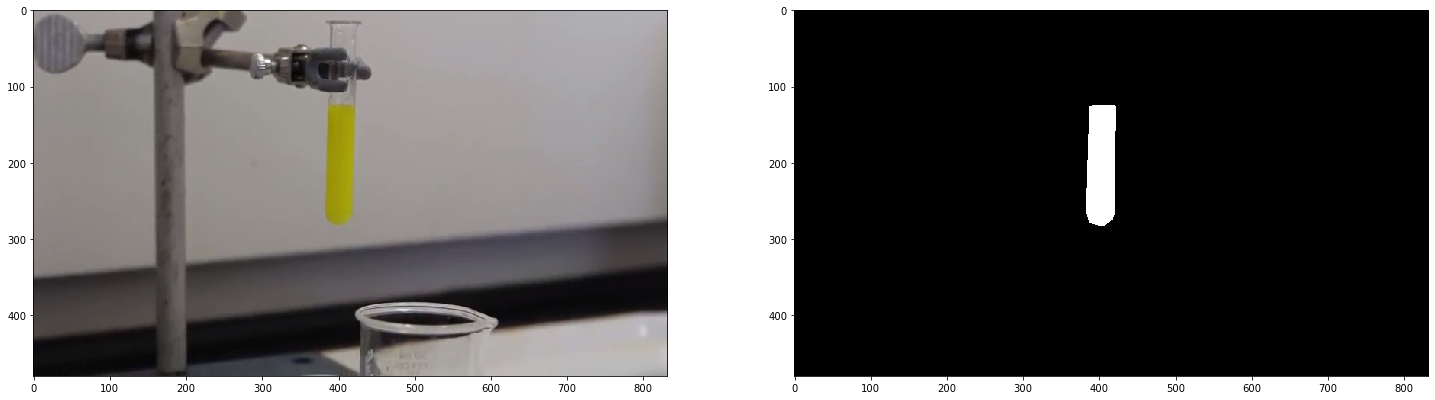

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25)) 

idx = 0

a = cv2.cvtColor(train_y[idx], cv2.COLOR_GRAY2BGR)
for_plot = a * 255

axes[0].imshow(train_x[idx][:,:,::-1])
axes[1].imshow(for_plot)
# cv2.imshow('img', train_y[-1])
# cv2.waitKey(0)

plt.show()

In [16]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
# test_x = preprocess_input(test_x)

In [18]:
# base_model = VGG16(weights='imagenet', input_shape=(width, height, 3), include_top=False)

# base_out = base_model.output

# up = UpSampling2D(32, interpolation='bilinear')(base_out)
# conv = Conv2D(1, (1, 1))(up)
# conv = Activation('sigmoid')(conv)

# model = Model(input=base_model.input, output=conv)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')


In [19]:

best_w = keras.callbacks.ModelCheckpoint('../models/fcn_best.h5', 
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('../models/fcn_last.h5', 
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=adam, 
              loss=bce_jaccard_loss, 
              metrics=[iou_score]
             )

In [20]:
def data_generator(X, Y, batch_size, samples_per_epoch):
    
#     train_x = preprocess_input(train_x)
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:
        for x_i, y_i in zip(X, Y):
            train_x, train_y = augmentation([x_i], [y_i])
            train_x, train_y = shuffle(train_x, train_y)
            
            train_x = preprocess_input(train_x)
            
            for x, y in zip(train_x, train_y):
                if batch_size > 1:
                    X_batch = np.array([x[batch_size*counter:batch_size*(counter+1)]]).astype('float32')
                    y_batch = np.array([y[batch_size*counter:batch_size*(counter+1)]]).astype('float32')
                else:
                    X_batch = np.array([x])
                    y_batch = np.array([y])
                counter += 1
                yield X_batch,y_batch

                if counter >= number_of_batches:
                    counter = 0

In [ ]:
# history = model.fit(train_x, train_y, epochs=50, verbose=1, batch_size=1, callbacks=callbacks, validation_split=0.3)

batch_size = 1
print(len(train_x))
samples_per_epoch = len(train_x) * 2 * 3 * 8
val_samples_per_epoch = len(val_x) * 2 * 3 * 8


history = model.fit_generator(data_generator(train_x, train_y, batch_size, samples_per_epoch),
    epochs=30,
    steps_per_epoch = samples_per_epoch/batch_size,
    validation_data = data_generator(val_x, val_y, batch_size, val_samples_per_epoch),
    validation_steps = val_samples_per_epoch/batch_size*2
)

922
Epoch 1/30
44256/44256 [==============================] - 13088s 296ms/step - loss: 0.3773 - iou_score: 0.6626 - val_loss: 1.1678 - val_iou_score: 0.0197
Epoch 2/30
26715/44256 [=================>............] - ETA: 1:26:58 - loss: 0.4394 - iou_score: 0.6115

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_x, test_y, batch_size=1)

In [ ]:
pred = model.predict(test_x, batch_size=1)

In [ ]:
axes = plt.subplots(nrows=3, ncols=2, figsize=(25,25))[1]
for idx, axis in enumerate(axes):
    axis[0].imshow(test_x[idx][:,:,::-1])
    axis[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

In [ ]:
best_model = sm.Unet(BACKBONE)

best_model.load_weights("../models/fcn_best.h5")
best_model.compile(optimizer=adam, loss=bce_jaccard_loss, 
              metrics=[iou_score])

In [ ]:
best_model.evaluate(test_x, test_y, batch_size=1)

In [ ]:
pred = best_model.predict(test_x, batch_size=1)

In [ ]:
axes = plt.subplots(nrows=3, ncols=2, figsize=(25,25))[1]
for idx, axis in enumerate(axes):
    axis[0].imshow(test_x[idx][:,:,::-1])
    axis[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()